# Multimodal classification for humanitarian rescue efforts

## Aims of this tutorial
Multimodal data fusion and multi-omics are one of the next frontiers in the healthcare domain. MONAI offers various ways to work with multimodal data. In this tutorial, we are going to explore the usage of the `CSVDataset` class in MONAI to load tabular data with pointers to multimodal data sources (images and text). Often, it is desirable to use pre-trained [foundational models](https://fsi.stanford.edu/publication/opportunities-and-risks-foundation-models) as backbone architectures which convert input samples into embedding vectors. In this tutorial, we explore two ways to achieve this;
   * As a **MONAI transform**: here, the backbone model is considered purely as an extractor of feature vectors. This is suitable if there is no need/possibility to fine-tune the backbone model (e.g. very large NLP models).
   * As **part of the model architecture**: here, the backbone model is part of the multimodal network architecture. This is useful, if backprop and fine-tuning of (parts of) the backbone model is desired (e.g. a ResNet model).

We implement both concepts and apply them to a multimodal dataset containing text and image data.

## Get CrisisMMD tweet dataset (2D images + text)

The [CrisisNLP](https://crisisnlp.qcri.org/) initiative provides datasets designed "to help researchers and technologists to advance research on humanitarian crises computing, by developing new computational models, innovative techniques, and systems useful for humanitarian aid." 

For this tutorial, we are going to use the [CrisisMMD multimodal Twitter dataset](https://crisisnlp.qcri.org/crisismmd). It consists of several thousands of manually annotated tweets and images collected during seven major natural disasters including earthquakes, hurricanes, wildfires, and floods that happened in the year 2017 across different parts of the World. 

The original **CrisisMMD dataset (v2.0)** contains 16058 and 18082 **tweet texts and images**, and three classification tasks ("Informativeness", "Humanitarian", "Damage Severity") as described in [1]. We use a pre-processed version of this dataset with consolidated labels for only the "Humanitarian" task and fixed splits into training-, validation- and test sets [2]. The "Humanitarian" task is to classify tweets into 5 classes (see below), which indicate whether the tweet has a relevance for humanitarian rescue efforts. 

**License:** CrisisNLP datasets have a custom [Terms of Use](https://crisisnlp.qcri.org/terms-of-use.html) agreement, which allow public research, but require citation of the following two works in case of re-use:

   * [1] Firoj Alam, Ferda Ofli, and [Muhammad Imran](http://mimran.me/), CrisisMMD: Multimodal Twitter Datasets from Natural Disasters, In Proceedings of the 12th International AAAI Conference on Web and Social Media (ICWSM), 2018, Stanford, California, USA. [[arXiv]](https://arxiv.org/pdf/1805.00713.pdf)|[[Bibtex]](https://crisisnlp.qcri.org/bibs/crisismmd18_bib.html)
   * [2] Ferda Ofli, Firoj Alam, and [Muhammad Imran](http://mimran.me/), Analysis of Social Media Data using Multimodal Deep Learning for Disaster Response, In Proceedings of the 17th International Conference on Information Systems for Crisis Response and Management (ISCRAM), 2020, USA. [[arXiv]](https://arxiv.org/abs/2004.11838)|[[Bibtex]](https://crisisnlp.qcri.org/crisismmd_baseline_bib.html)


## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[transformers, pandas, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "from sklearn import preprocessing" || pip install -q scikit-learn==0.20.3
%matplotlib inline

## Download dataset

Download dataset and pre-processed labels / data splits:

In [ ]:
# download and (quiet) extract CrisisMMD dataset
!wget https://crisisnlp.qcri.org/data/crisismmd/CrisisMMD_v2.0.tar.gz
!tar -xvf CrisisMMD_v2.0.tar.gz &>/dev/null

# get cleaned labels and official train/valid/test split
!wget https://crisisnlp.qcri.org/data/crisismmd/crisismmd_datasplit_agreed_label.zip
!unzip -q crisismmd_datasplit_agreed_label.zip

## Import dependencies

In [5]:
%config Completer.use_jedi = False

# python basic imports
import os
import time
from datetime import datetime 
from tqdm import tqdm

# data science imports
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from sklearn import preprocessing # we use LabelEncoder later

# torch imports
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer, AutoModel #, pipeline

# monai imports
import monai
# ready-made MONAI transforms
from monai.transforms import (
    AsChannelFirstd,
    Compose,
    Lambdad,
    LoadImaged,
    NormalizeIntensityd,
    Resized,
    ScaleIntensityRanged,
    ToTensord,
    Transform
)
#ScaleIntensityd,
from monai.data import PILReader
# Datasets and DataLoader
from monai.data import Dataset, CSVDataset
from monai.data import DataLoader
# imports for custom MONAI transforms
from monai.utils.enums import TransformBackends
# imports for custom MONAI dictionary transforms
from typing import Any, Callable, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union
from monai.config import DtypeLike, KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from monai.transforms.transform import MapTransform
from monai.transforms.utils import is_positive
from monai.utils import ensure_tuple, ensure_tuple_rep
# network models
from monai.networks.nets import TorchVisionFCModel

## Print configuration

In [2]:
monai.config.print_config()

MONAI version: 0.8.1
Numpy version: 1.22.3
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.2.0
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.2.4
einops version: 0.3.2
transformers version: 4.11.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Load dataframes and check contents of data table

Let's peak into the dataset:

In [3]:
import os
import pandas as pd

df_train = pd.read_csv(os.path.join(os.getcwd(),
                              'crisismmd_datasplit_agreed_label', 
                              'task_humanitarian_text_img_agreed_lab_train.tsv'),
                       sep='\t')
df_valid = pd.read_csv(os.path.join(os.getcwd(),
                              'crisismmd_datasplit_agreed_label', 
                              'task_humanitarian_text_img_agreed_lab_dev.tsv'),
                       sep='\t')

print(f'Nr. rows in train set: {df_train.shape[0]}')
print(f'Nr. rows in valid set: {df_valid.shape[0]} \n')
print('Classes in training set:')
print(df_train.label.value_counts())
df_train.head(5)

Nr. rows in train set: 6126
Nr. rows in valid set: 998 

Classes in training set:
not_humanitarian                          3252
other_relevant_information                1279
rescue_volunteering_or_donation_effort     912
infrastructure_and_utility_damage          612
affected_individuals                        71
Name: label, dtype: int64


,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
1,california_wildfires,917793137925459968,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
2,california_wildfires,917793137925459968,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
3,california_wildfires,917815040962695168,917815040962695168_2,RT @TheAtlantic: Photos of California's destru...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
4,california_wildfires,917828283047260161,917828283047260161_0,Why California's #wildfires are worse in the f...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,other_relevant_information,Positive


## Define a MONAI transform for text embedding

We write our own custom MONAI transform which contains a Huggingface backbone model to create text embeddings. Since we are dealing with Tweet texts in this example, we use the `cardiffnlp/twitter-roberta-base` backbone. We do not want to finetune any parameters in this model, and can therefore put this backbone into a transform, instead of making it part of our trainable model. 

In [4]:
# tweet embedding example
# source: https://huggingface.co/cardiffnlp/twitter-roberta-base

# MONAI transform for text embedding
class TextEmbeddingHuggingface(Transform):
    """
    Embedding of text using a pre-trained NLP model.

    Args:
        text: text to embed.
    """

    backend = [TransformBackends.TORCH, TransformBackends.NUMPY]

    def __init__(self, 
                 device=None, 
                 huggingface_model_id="cardiffnlp/twitter-roberta-base", 
                 preprocessing=None) -> None:
        """
        Set up device, huggingface material (tokenizer, model) and preprocessing function
        Args:
            text: text to embed.
            huggingface_model_id: identifier for Huggingface model. Default is: 
                                  'cardiffnlp/twitter-roberta-base'
            preprocessing: function handle to preprocess tweet text (e.g. remove/shorten URLs etc.)    
        """
        # device settings        
        if device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device
        
        # huggingface tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained(huggingface_model_id)
        self.model = AutoModel.from_pretrained(huggingface_model_id).to(self.device)
        self.model.eval()
        
        # preprocessing
        if preprocessing is None: 
            # use default preprocessing for tweets according to huggingface
            self.preprocess = self.tweet_preprocess

    def __call__(self, text):
        """
        Run preprocessing, and then the forward pass of the NLP model to obtain the text embedding
        """
        text = self.preprocess(text)
        encoded_input = self.tokenizer(text, padding=True, return_tensors='pt')
        for key in encoded_input.keys():
            encoded_input[key] = encoded_input[key].to(self.device)
        with torch.no_grad():
            features = self.model(**encoded_input)
        return features[0].mean(axis=1)
    
    def tweet_preprocess(self, texts):
        """
        Input:  Single tweet string (gets converted to a list with a single string), 
                or a list of strings as input, returns a list of strings. 
        Output: A list of pre-processed strings
        
        Shortens URLs and Twitter user handles.
        """
        if isinstance(texts,str):
            texts = [texts]
        new_texts = []
        for text in texts:
            new_text = []
            for t in text.split(" "):
                t = '@user' if t.startswith('@') and len(t) > 1 else t
                t = 'http' if t.startswith('http') else t
                new_text.append(t)
            new_text = " ".join(new_text)
            new_texts.append(new_text)
        return new_texts
    
class TextEmbeddingHuggingfaced(MapTransform):
    """
    Dictionary-based version :py:class:`TextEmbeddingHuggingface`.
    
    Args:
        keys: keys of the corresponding items to be transformed.
            See also: :py:class:`monai.transforms.compose.MapTransform`
        device: Huggingface backbone model can reside on CPU or GPU:x. 
        huggingface_model_id: identifier for Huggingface model. Default is: 
                              'cardiffnlp/twitter-roberta-base'
        preprocessing: function to preprocess tweet text (e.g. remove/shorten URLs etc.)
        allow_missing_keys: don't raise exception if key is missing.
    """

    backend = TextEmbeddingHuggingface.backend

    def __init__(
            self,
            keys,
            device = None, # str 
            huggingface_model_id = "cardiffnlp/twitter-roberta-base", # str
            preprocessing = None, # function
            allow_missing_keys = True ): #bool 
        super().__init__(keys, allow_missing_keys)
        self.text_embedder = TextEmbeddingHuggingface(device=device, 
                                                      huggingface_model_id=huggingface_model_id, 
                                                      preprocessing=preprocessing)

    def __call__(self, data):
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.text_embedder(texts)
        return d

test_time = True
if test_time:
    text_embedder_cpu = TextEmbeddingHuggingface(device='cpu')
    text_embedder_gpu = TextEmbeddingHuggingface(device='cuda:0')
    
    # test text embedding on a single tweet    
    nr_texts = 256
    texts = df_train.tweet_text[0:nr_texts].tolist()
    
    t0 = time.time()
    emb_cpu = text_embedder_cpu(texts)
    dt_cpu = time.time()-t0
    print('Embedding of %d tweets on CPU - Elapsed time: %0.3f'%(nr_texts, dt_cpu))
    
    t0 = time.time()
    emb_gpu = text_embedder_gpu(texts)
    dt_gpu = time.time()-t0
    print('Embedding of %d tweets on GPU - Elapsed time: %0.3f'%(nr_texts, dt_gpu))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_h

Embedding of 256 tweets on CPU - Elapsed time: 6.100
Embedding of 256 tweets on GPU - Elapsed time: 0.332


## Define transforms

The transforms pipeline contains image I/O and pre-processing. Note that we need to specify a PILReader because the dataset contains both jpg (RGB) and png (RGBA) images, which both need to be converted to RGB.

In [6]:
# transforms for image I/O and transform
transforms_train = Compose([
        Lambdad(keys="image", func=lambda filepath: os.path.join(os.getcwd(),
                                                                 'CrisisMMD_v2.0',
                                                                 filepath)), # append base path to relative image path
        LoadImaged(keys="image", image_only=True, reader=PILReader(converter=lambda image: image.convert("RGB"))),
        AsChannelFirstd(keys="image"),
        Resized(keys="image", spatial_size=(224,224)),
        ScaleIntensityRanged(keys="image", a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0),
        NormalizeIntensityd(keys="image", subtrahend=np.array([0.485, 0.456, 0.406]), divisor=np.array([0.229, 0.224, 0.225]), channel_wise=True),
        ToTensord(keys="image"),
        ]
)

# significantly faster version if only text is used (leave away image I/O transforms)
transforms_train_textonly = Compose([
        Lambdad(keys="image", func=lambda filepath: os.path.join(os.getcwd(),
                                                                 'CrisisMMD_v2.0',
                                                                 filepath)), # append base path to relative image path
        ]
)


##  Load and visualize example batch (N=32)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid r

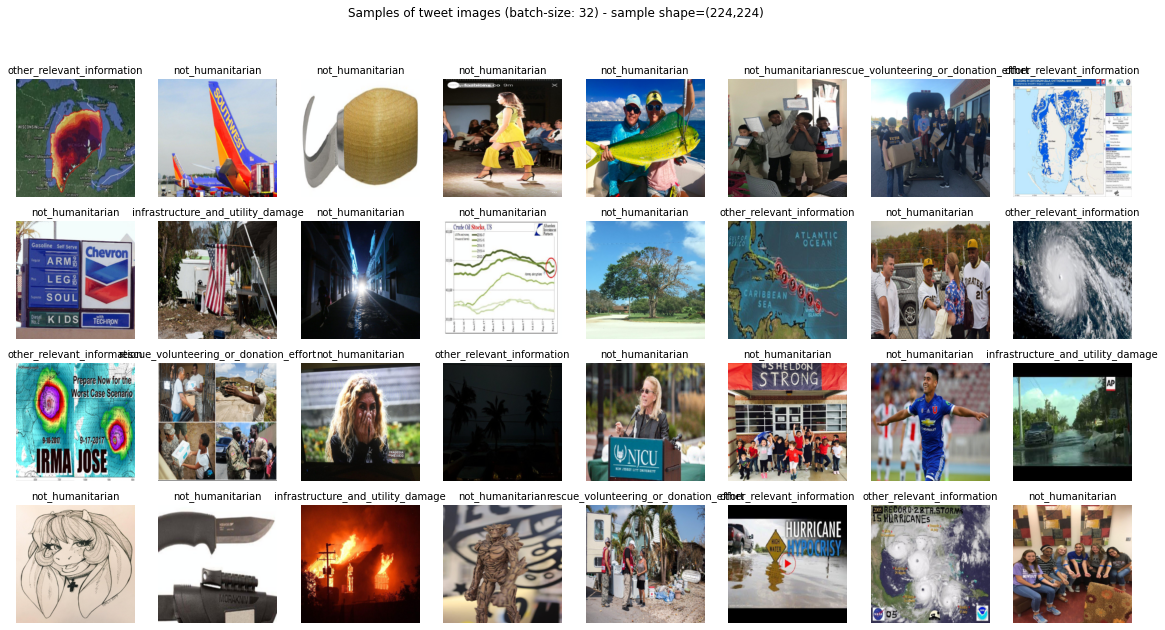

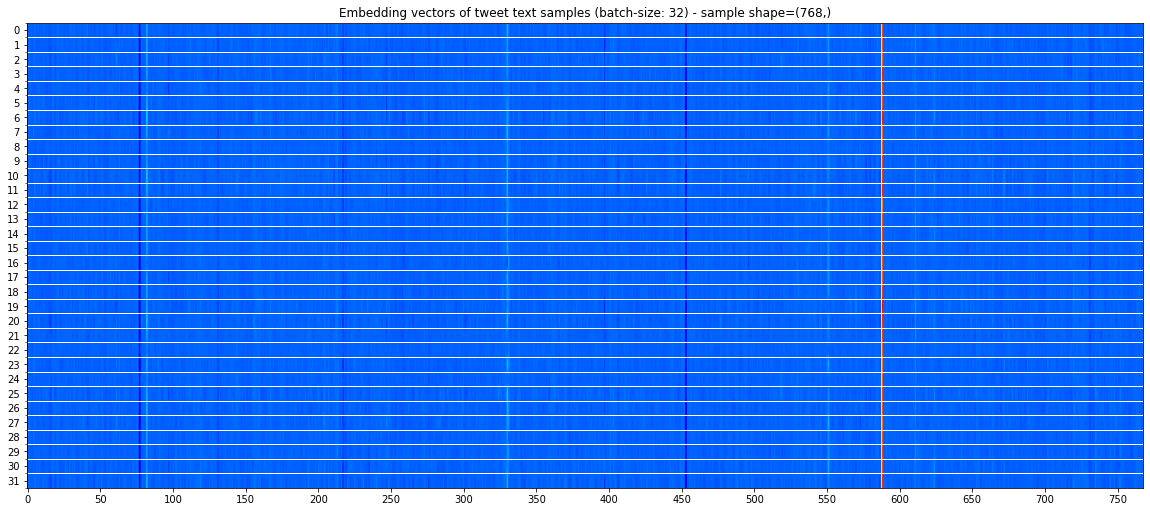

In [7]:
text_embedder = TextEmbeddingHuggingface(device='cpu')

torch.manual_seed(0)
batch_size = 32

data_viz = CSVDataset(
                  src=df_train,
                  col_names=['image', 'tweet_text', 'label'], 
                  col_types = {
                      "image": {"type": str},
                      "tweet_text": {"type": str, "default": "empty tweet"},
                      "label": {"type": str, "default": 'not_humanitarian'},
                  }, 
                  col_groups=None, 
                  transform=transforms_train
)

loader_viz = DataLoader(dataset=data_viz, batch_size=batch_size, shuffle=True)
blob = next(iter(loader_viz))
blob['tweet_text'] = text_embedder(blob['tweet_text'])

fig, axs = plt.subplots(4,8,figsize=(20,10))
for idx, img in enumerate(blob['image']):
    img_viz = (np.flipud(img.permute(2,1,0))*np.array([0.229, 0.224, 0.225]))+np.array([0.485, 0.456, 0.406]) # undo normalization to [-1.0,...1.0]
    axs[int(np.floor(idx/8))][idx%8].imshow(img_viz, origin='lower')
    axs[int(np.floor(idx/8))][idx%8].set_title(blob['label'][idx], fontsize=10)
    axs[int(np.floor(idx/8))][idx%8].set_axis_off()
fig.suptitle(f'Samples of tweet images (batch-size: {batch_size}) - sample shape=(224,224)')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(20,10))
plt.imshow(blob['tweet_text'].cpu(), cmap='jet', aspect=10)
ax.set_title(f'Embedding vectors of tweet text samples (batch-size: {batch_size}) - sample shape=(768,)')
ax.set_xticks(np.arange(0,767,50))
ax.set_yticks(np.arange(batch_size))
ax.set_yticks(np.arange(-.5, batch_size, 1), minor=True)
plt.grid(which='minor', axis='y', color='w', linestyle='-', linewidth=1.0)
plt.show()


## Model definitions

We create 3 models: 
   
   * **TweetOnlyNet:** Classifies tweets based only on tweet text. This net takes RoBERTa embedddings from our `TextEmbeddingHuggingface()` transform as input (768-dim), followed by a single linear layer (256-dim), ReLu activation, towards the classification layer (5-class).
   * **ImageOnlyNet:** Classifies tweets based only on tweet images. This net contains a pre-trained ResNet50 CNN, provided by MONAI's `TorchVisionFCModel` class. We freeze all layers except its output layer (specified to be 256-dim), and attach the classification layer (5-class).
   * **MultimodalNet:** Classifies tweets based on both multimodal text+image data. This net concatenates tweet text and image feature vectors (analoguos to above 2 nets) into a multimodal embedding, followed by a linear layer+ReLU (256-dim), towards the classification layer (5-class).

The figure below illustrates the network architectures. In this figure, **colored boxes/arrows denote trainable layers**, while **grey boxes denote pre-trained backbone models** which serve as multimodal input heads. Note also that the RoBERTa backbone model is implemented as a MONAI transform and can only serve feature vectors, while the ResNet50 model is part of the model architecture and can therefore be fine-tuned. 

Please note that, for clarity's sake, all three models as well as the multimodal embedding mechanism (concatenation) are kept very simple in this example. The goal is not to beat benchmark models, but to show how to combine several pre-trained input heads for multimodal data processing.

<div>
<img src=./media/fig_crisismmd_flow.png width="1000" alt="Network architectures and data flow"/>
</div>

In [8]:
class TweetOnlyNet(nn.Module):
    def __init__(self, n_classes, hidden_size=256):
        super().__init__()
        self.fc1 = nn.Linear(768,hidden_size)
        self.fc2 = nn.Linear(hidden_size,n_classes)
        
    def forward(self, text_embeddings):
        '''Forward pass'''
        x = F.relu(self.fc1(text_embeddings))
        x = self.fc2(x)
        return x

class ImageOnlyNet(nn.Module):
    def __init__(self, n_classes, hidden_size_cnn=256):
        super().__init__()
        # the CNN implicitly contains a fc layer which embeds into num_classes dimensions
        self.cnn = TorchVisionFCModel("resnet50", num_classes=hidden_size_cnn, use_conv=True, pretrained=True)
        # Avoid catastrophic forgetting --> freeze all ResNet50 layers except last fc layer
        for param in self.cnn.parameters():
            param.requires_grad = False 
        for param in self.cnn.fc.parameters():
            param.requires_grad = True
        # add another classification layer fc2
        self.fc1 = nn.Linear(hidden_size_cnn,n_classes)
        
    def forward(self, images):
        '''Forward pass'''
        x = F.relu(self.cnn(images))
        x = self.fc1(x.squeeze())
        return x

class MultimodalNet(nn.Module):
    def __init__(self, n_classes, hidden_size_fc_image=256, hidden_size=256):
        super().__init__()
        # same vision model as above, again implicitly containing an ebmedding layer fc1
        self.cnn = TorchVisionFCModel("resnet50", num_classes=hidden_size_fc_image, use_conv=True, pretrained=True)
        for param in self.cnn.parameters():
            param.requires_grad = False 
        for param in self.cnn.fc.parameters():
            param.requires_grad = True
        # classification layer - operates on concatenated (text+image)-embedding vectors
        self.fc1 = nn.Linear(768+hidden_size_fc_image,hidden_size)
        self.fc2 = nn.Linear(hidden_size,n_classes)
        
    def forward(self, images, text_embeddings):
        x1 = F.relu(self.cnn(images))
        x2 = text_embeddings

        x = torch.cat((x1.squeeze(), x2), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Typical torch training and validation loop

In [11]:
def train(train_loader, model, criterion, optimizer, device, data_keys, 
          label_encoder=None, text_embedder=None, 
          summary_writer=None, summary_writer_offset=0):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for idx, batch_data in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        batch_data['tweet_text'] = text_embedder(batch_data['tweet_text'])
        data = [batch_data[key].to(device) for key in data_keys]
        targets = batch_data['label']
        if label_encoder is not None:
            targets = label_encoder.transform(targets)
        targets = torch.from_numpy(targets).to(device)
        
        # Forward pass
        predictions = model(*data) 
        loss = criterion(predictions, targets) 
        
        if summary_writer is not None:
            summary_writer.add_scalar("Loss/train", loss, global_step=summary_writer_offset+idx)
        
        running_loss += loss.item() * data[0].size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device, data_keys, 
             label_encoder=None, text_embedder=None, 
             summary_writer=None, summary_writer_offset=0):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for batch_data in valid_loader:

            batch_data['tweet_text'] = text_embedder(batch_data['tweet_text'])
            data = [batch_data[key].to(device) for key in data_keys]
            targets = batch_data['label']
            if label_encoder is not None:
                targets = label_encoder.transform(targets)
            targets = torch.from_numpy(targets).to(device)

            # Forward pass
            predictions = model(*data) 
            loss = criterion(predictions, targets) 

            running_loss += loss.item() * data[0].size(0)
        epoch_loss = running_loss / len(valid_loader.dataset)
        if summary_writer is not None:
            summary_writer.add_scalar("Loss/valid", epoch_loss, global_step=summary_writer_offset)
    
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, 
                  data_keys=None, label_encoder=None, summary_writer=None, 
                  text_embedder=None, print_every=1):
    '''
    Function defining the entire training loop
    '''
    if data_keys is None:
        print('Training loop requires list of target data keys in batch dictionary.')
        return None, None, None
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in tqdm(range(0, epochs)):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device,
                                             data_keys=data_keys, label_encoder=label_encoder, 
                                             text_embedder=text_embedder, 
                                             summary_writer=summary_writer,
                                             summary_writer_offset=len(train_loader)*epoch)
        train_losses.append(train_loss)

        # validation
        if epoch % print_every == (print_every - 1):
            with torch.no_grad():
                model, valid_loss = validate(valid_loader, model, criterion, device,
                                             data_keys=data_keys, label_encoder=label_encoder,
                                             text_embedder=text_embedder,
                                             summary_writer=summary_writer,
                                             summary_writer_offset=len(train_loader)*epoch)
                valid_losses.append(valid_loss)
                
                #print(f'{datetime.now().time().replace(microsecond=0)} --- '
                #      f'Epoch: {epoch}\t'
                #      f'Valid loss: {valid_loss:.4f}\t')
    
    return model, optimizer, (train_losses, valid_losses)

labels = ['not_humanitarian', 
          'other_relevant_information',
          'rescue_volunteering_or_donation_effort',
          'infrastructure_and_utility_damage',
          'affected_individuals']
label_enc = preprocessing.LabelEncoder()
label_enc.fit(labels)

DEVICE = 'cuda:1'
RANDOM_SEED = 0
LEARNING_RATE = 0.0005
BATCH_SIZE = 128
N_EPOCHS = 20
N_CLASSES = 5

monai.utils.set_determinism(seed=0, additional_settings=None)
torch.manual_seed(RANDOM_SEED)

for model_tag in ['tweet_text', 'image', 'multimodal']:
    if model_tag=='image':
        model_data_keys = ['image']
        model = ImageOnlyNet(n_classes=N_CLASSES).to(DEVICE)
        transforms = transforms_train
    elif model_tag=='tweet_text':
        model_data_keys = ['tweet_text']
        model = TweetOnlyNet(n_classes=N_CLASSES).to(DEVICE)
        transforms = transforms_train_textonly
    else: # model_tag=='multimodal':
        model_data_keys = ['image', 'tweet_text']
        model = MultimodalNet(n_classes=N_CLASSES).to(DEVICE)
        transforms = transforms_train

    data_train = CSVDataset(
                      src=df_train,
                      col_names=['image', 'tweet_text', 'label'], 
                      col_types = {
                          "image": {"type": str},
                          "tweet_text": {"type": str, "default": "empty tweet"},
                          "label": {"type": str, "default": 'not_humanitarian'},
                      }, 
                      col_groups=None, 
                      transform=transforms, 
                      kwargs_read_csv={'sep': '\t'}
    )
    loader_train = DataLoader(dataset=data_train, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=0)#prefetch_factor=16)

    data_valid = CSVDataset(
                      src=df_valid,
                      col_names=['image', 'tweet_text', 'label'], 
                      col_types = {
                          "image": {"type": str},
                          "tweet_text": {"type": str, "default": "empty tweet"},
                          "label": {"type": str, "default": 'not_humanitarian'},
                      }, 
                      col_groups=None, 
                      transform=transforms, 
                      kwargs_read_csv={'sep': '\t'}
    )
    loader_valid = DataLoader(dataset=data_valid, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=0)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    text_embedder = TextEmbeddingHuggingface(device=DEVICE)
    writer = SummaryWriter('runs/model_%s'%model_tag)
    model, optimizer, _ = training_loop(model, criterion, optimizer, loader_train, loader_valid, N_EPOCHS, DEVICE,
                                        data_keys=model_data_keys, label_encoder=label_enc, 
                                        text_embedder=text_embedder, summary_writer=writer)
    writer.flush()
    writer.close()

# start tensorboard via 
# tensorboard --logdir=./runs --port=6007 --bind_all 


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 20/20 [02:49<00:00,  8.46s/it]
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dec

## Result and discussion

The figure below shows the Tensorboard loss curves for training and validation set, for the three models `TweetOnlyNet`, `ImageOnlyNet`, and `MultimodalNet`. Among single-modal models, tweet text data clearly outperforms image data. However, a multimodal combination of text and images outperforms the single-modal models. Note the clear overfitting pattern in the validation loss curves, particularly in the multimodal model. 

There are many ways to improve this toy example:
   * **Counteract overfitting:** by early stopping, or by modifying the simple network architectures to avoid overfitting (e.g. by including dropout into the MLP output heads), or by adding random image augmentations into the transform pipelines. 
   * **Model complexity:** Introduce more/wider MLP layers at the end of the model(s).
   * **Multimodal embedding:** The multimodal model creates an embedding via concatenation of image+text latents. This is arguably the simplest mechanism for multimodal fusion. Multimodal fusion with attention via a transformer layer is a slightly more complex method, but it can be much more effective. In MONAI, this is implemented in the [TransCheX](https://docs.monai.io/en/stable/networks.html?highlight=transchex#monai.networks.nets.Transchex) model, which also fuses multimodal text and images. For more information, check out the accompanying [tutorial notebook](https://github.com/Project-MONAI/tutorials/blob/master/multimodal/openi_multilabel_classification_transchex/transchex_openi_multilabel_classification.ipynb). 


<div>
<img src=./media/fig_crisismmd_losses.png width="800" alt="Network architectures and data flow"/>
</div>